#   HOMEWORK 2 - detecting brest cancer

Full Intro: https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2024/03/1-Python-Programming.pdf

Documentation: https://pandas.pydata.org/docs/

Documentation: https://matplotlib.org/stable/index.html

Documentation: https://scikit-learn.org/1.5/user_guide.html

In [1]:
# LOAD ALL LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#   Exercise 1-2

## Read file excel

Load the file into the Disk on the left in the File Section (Folder Icon). Next, read the file using pandas by passing the path.

In [2]:
dataframe=pd.read_excel("breast.xlsx")

In a Jupyter Notebook cell, you can print a subset of the representation by simply calling the name of the variable containing the DataFrame.

In [3]:
# print dataset
dataframe.sample(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
147,'60-69','ge40','10-14','0-2','no','1','left','left_low','no','no-recurrence-events'
132,'40-49','premeno','30-34','0-2','no','3','right','right_up','no','recurrence-events'
74,'30-39','premeno','25-29','6-8','yes','3','left','right_low','yes','recurrence-events'
80,'50-59','lt40','15-19','0-2','no','2','left','left_low','no','no-recurrence-events'
251,'50-59','ge40','10-14','0-2','no','2','left','left_low','no','no-recurrence-events'


Remove duplicated elements

In [4]:
print(f"Rows before removing duplicates: {dataframe.shape[0]}")
dataframe = dataframe.drop_duplicates()
print(f"Rows after removing duplicates: {dataframe.shape[0]}")

Rows before removing duplicates: 286
Rows after removing duplicates: 272


## Select Label and apply encoding

Separate the dataset into features, referred to as X, and labels, referred to as y.


In [5]:
# Separate features (X) and labels (y)
X = dataframe.drop(columns=['Class'])
y = dataframe['Class']

### Encoding

I needed to encode both the features and the target variable (`Class`) because most machine learning models work with numerical data. Here's what I did:

1. **Age, Tumor Size, and Inv-Nodes**: These were ranges (e.g., `'40-49'`), so I converted them to their midpoints (e.g., `45`) to keep their continuous nature while making them numerical.
2. **Menopause**: I assigned ordinal values (`'lt40' → 1`, `'premeno' → 2`, `'ge40' → 3`) to reflect the natural progression of menopause stages.
3. **Node-Caps and Breast**: These were binary features (`'yes'` or `'no'`, `'left'` or `'right'`), so I mapped them to `1/0` for simplicity.
4. **Deg-Malig**: This feature already represented ordinal values (`1`, `2`, `3`), so no changes were needed.
5. **Class (Target Variable)**: I used `LabelEncoder` to convert the target classes (`'recurrence-events'` and `'no-recurrence-events'`) into integers, making them suitable for the model.

These encodings ensure the data is clean, numerical, and ready for machine learning while preserving the meaning of the original features.

In [6]:
def calculate_midpoint(range_str):
    start, end = map(int, range_str.strip("'").split('-'))
    return (start + end) / 2

In [7]:
encoder = LabelEncoder()

In [8]:
menopause_map = {"'lt40'": 1, "'premeno'": 2, "'ge40'": 3}

# Apply encodings
X.loc[:, 'age'] = X['age'].apply(calculate_midpoint)
X.loc[:, 'menopause'] = X['menopause'].map(menopause_map)
X.loc[:, 'tumor-size'] = X['tumor-size'].apply(calculate_midpoint)
X.loc[:, 'inv-nodes'] = X['inv-nodes'].apply(calculate_midpoint)
X.loc[:, 'node-caps'] = encoder.fit_transform(X['node-caps'])
X.loc[:, 'deg-malig'] = X['deg-malig'].apply(lambda x: int(str(x).strip("'")) if isinstance(x, str) else x)
breast_dummies = pd.get_dummies(X['breast'], prefix='breast')
X = pd.concat([X.drop(columns=['breast']), breast_dummies], axis=1)
breast_quad_dummies = pd.get_dummies(X['breast-quad'], prefix='breast-quad')
X = pd.concat([X.drop(columns=['breast-quad']), breast_quad_dummies], axis=1)
X.loc[:, 'irradiat'] = encoder.fit_transform(X['irradiat'])

X_encoded = X

In [9]:
y_encoded = encoder.fit_transform(y)

##  Use the decision tree classifier model.

[Use DecisionTreeClassifier() and its .fit function]

In [10]:
# Initialize the Decision Tree Classifier, set criterion and max depth
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Train the Decision Tree Classifier
dt_classifier.fit(X_encoded, y_encoded)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

Obiettivo: Controllare la complessità del modello (profondità) e vedere l’accuratezza complessiva sul set di addestramento.

##  Print the structure of the decision tree

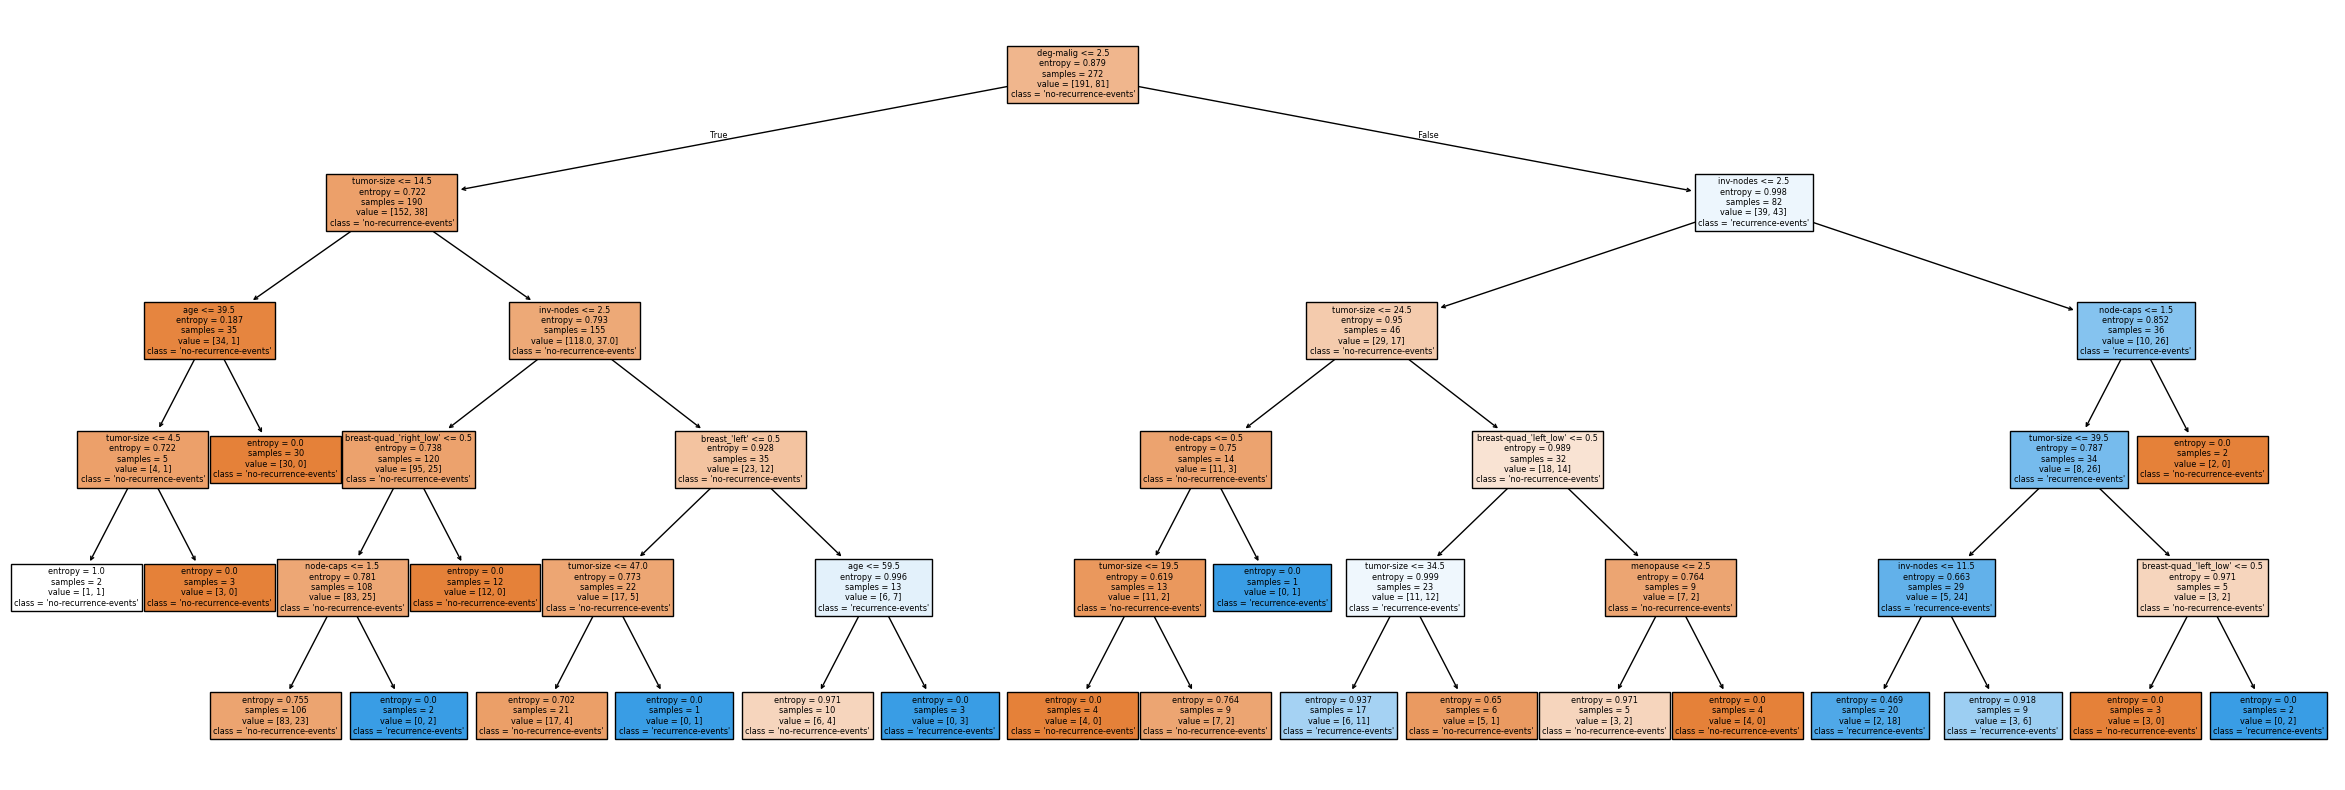

In [11]:
plt.figure(figsize=(30, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_encoded.columns, class_names=encoder.classes_)

# Display the plot
plt.show()

# 1a)

In [12]:
feature_importances = dt_classifier.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
2                tumor-size    0.241993
5                 deg-malig    0.239404
3                 inv-nodes    0.130641
4                 node-caps    0.128183
10   breast-quad_'left_low'    0.079771
0                       age    0.074128
12  breast-quad_'right_low'    0.051499
7             breast_'left'    0.030100
1                 menopause    0.024280
6                  irradiat    0.000000
8            breast_'right'    0.000000
9     breast-quad_'central'    0.000000
11    breast-quad_'left_up'    0.000000
13   breast-quad_'right_up'    0.000000
14            breast-quad_?    0.000000


### Most Discriminative Attribute for Class Prediction

The most discriminative attribute is determined by examining the root node of the Decision Tree, as it provides the maximum information gain and best separates the dataset. Additionally, the `feature_importances_` attribute confirms the significance of each feature numerically.

The features with the highest importance score, as indicated in the sorted importance table, are `deg-malig` and `tumor-size`. These features play a pivotal role in predicting the target class.

# 1b)

In [13]:
# Decision tree depth
dt_classifier.get_depth()

5

### Height of the Decision Tree

The height of the generated Decision Tree, as obtained from the method `dt_classifier.get_depth()`, represents the maximum depth of the tree, which in this case is 5, that is also the max_depth.

#### Importance of Tree Depth
The depth of a Decision Tree impacts its performance in several ways:
- **Generalization vs. Overfitting**:
  - A shallow tree (low depth) might underfit the data, failing to capture important patterns.
  - A deep tree (high depth) might overfit, capturing noise and reducing generalization ability.
- **Model Complexity**: The depth controls the complexity of the model. A deeper tree can model more intricate patterns but at the cost of increased risk of overfitting.
- **Computation**: Shallower trees are computationally more efficient, both during training and inference.

In this case, the maximum depth was set to 5 to strike a balance between capturing the essential patterns and avoiding overfitting, ensuring that the model remains interpretable and generalizes well to unseen data.

# 1c)

### Identifying a Pure Partition in the Decision Tree

#### What is a Pure Partition?
A **pure partition** in a Decision Tree is a leaf node where all the samples belong to a single class. This indicates that the subset of data reaching that node is perfectly separated, making the prediction for that node 100% accurate.

#### Importance of Pure Partitions
- **Interpretability**: Pure partitions represent clear and confident decisions made by the tree.
- **Generalization**: While pure partitions can be desirable, an excessive number of them (especially in deep trees) may lead to overfitting.
- **Decision Thresholds**: Pure partitions help us understand the specific conditions under which the model confidently predicts a class.


## Impact Parameters

**Evaluate** the Tree by combining differen max depth and min impurity values

In [14]:
# Funzione per eseguire Grid Search
def perform_grid_search(X, y, param_grid):
    dt_classifier = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
    return grid_search, results_df

# Parametri da esplorare
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]
}

# Esegui il Grid Search
grid_search, results_df = perform_grid_search(X_encoded, y_encoded, param_grid)

### Grid Search and its Utility

#### What is Grid Search?
Grid Search is a method for finding the best hyperparameters for a model. It works by:
- Trying out different combinations of hyperparameters from a predefined grid.
- Using cross-validation to check how well each combination performs.
- Picking the one that gives the best results based on a metric like accuracy.

#### Why Use Grid Search?
1. **Saves Time**: Instead of manually testing different hyperparameters, Grid Search does it for you.
2. **Improves Accuracy**: Helps find the best settings to make the model as accurate as possible.
3. **Better Generalization**: Cross-validation ensures the chosen hyperparameters work well on unseen data.



In [15]:
# Funzione per riorganizzare e mostrare le configurazioni principali
def analyze_grid_results(results_df, top_n=5):
    configs = results_df[['params', 'mean_test_score']]
    configs_print = configs.copy()

    # Estrai parametri specifici
    for param in ['max_depth', 'min_impurity_decrease', 'min_samples_split', 'min_samples_leaf']:
        configs_print[param] = configs_print['params'].apply(lambda x: x.get(param, 'Default'))

    configs_print = configs_print[['mean_test_score', 'max_depth', 'min_impurity_decrease', 'min_samples_split', 'min_samples_leaf']]

    # Seleziona configurazioni chiave
    first_5 = configs_print.head(top_n)
    middle_5 = configs_print.iloc[len(configs_print) // 2 - 2: len(configs_print) // 2 + 3]
    last_5 = configs_print.tail(top_n)

    return first_5, middle_5, last_5, configs_print

# Mostra i risultati principali
first_5, middle_5, last_5, configs_print = analyze_grid_results(results_df)

print("First 5 Configurations:")
print(first_5.to_string(index=False))

print("\nMiddle 5 Configurations:")
print(middle_5.to_string(index=False))

print("\nLast 5 Configurations:")
print(last_5.to_string(index=False))

First 5 Configurations:
 mean_test_score  max_depth  min_impurity_decrease  min_samples_split  min_samples_leaf
        0.720471        7.0                   0.01                  5                 5
        0.720471        3.0                   0.01                  5                 3
        0.720471        3.0                   0.01                  2                 5
        0.720471        3.0                   0.01                  5                 5
        0.720471        3.0                   0.01                 10                 5

Middle 5 Configurations:
 mean_test_score  max_depth  min_impurity_decrease  min_samples_split  min_samples_leaf
        0.702222        5.0                    0.1                  5                 1
        0.702222        3.0                    0.1                  2                 1
        0.702222        3.0                    0.1                  5                 1
        0.702222        3.0                    0.1                 10 

In [16]:
def define_custom_configs(default_config, best_config):
    custom_config1 = default_config.copy()
    custom_config1['max_depth'] = 3

    custom_config2 = default_config.copy()
    custom_config2['min_impurity_decrease'] = 0.005

    custom_config3 = default_config.copy()
    custom_config3['min_samples_split'] = 5

    custom_config4 = default_config.copy()
    custom_config4['min_samples_leaf'] = 5

    return [
        ("Default Tree", default_config),
        ("Default + max_depth Modified", custom_config1),
        ("Default + min_impurity_decrease Modified", custom_config2),
        ("Default + min_samples_split Modified", custom_config3),
        ("Default + min_samples_leaf Modified", custom_config4),
        ("Best Configuration", best_config)
    ]


default_config = {
    'max_depth': None,
    'min_impurity_decrease': 0.0,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
best_config = configs_print.iloc[0].to_dict()


named_configs = define_custom_configs(default_config, best_config)

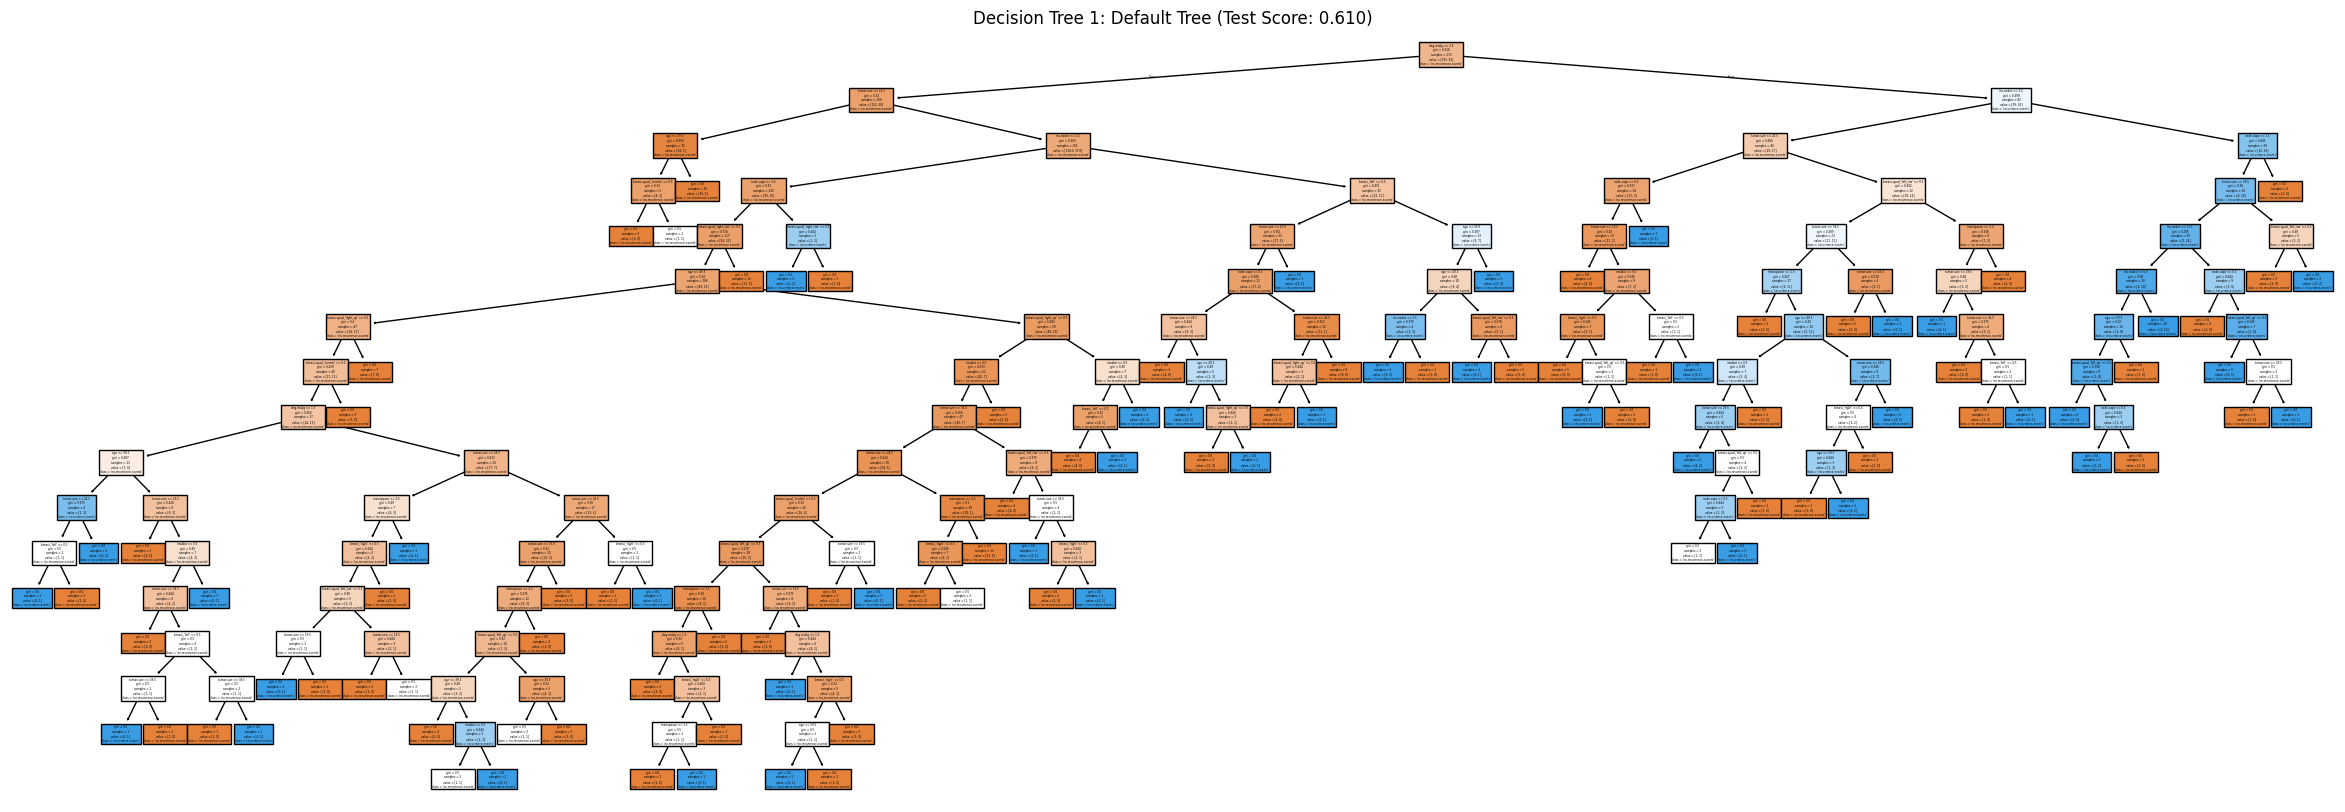

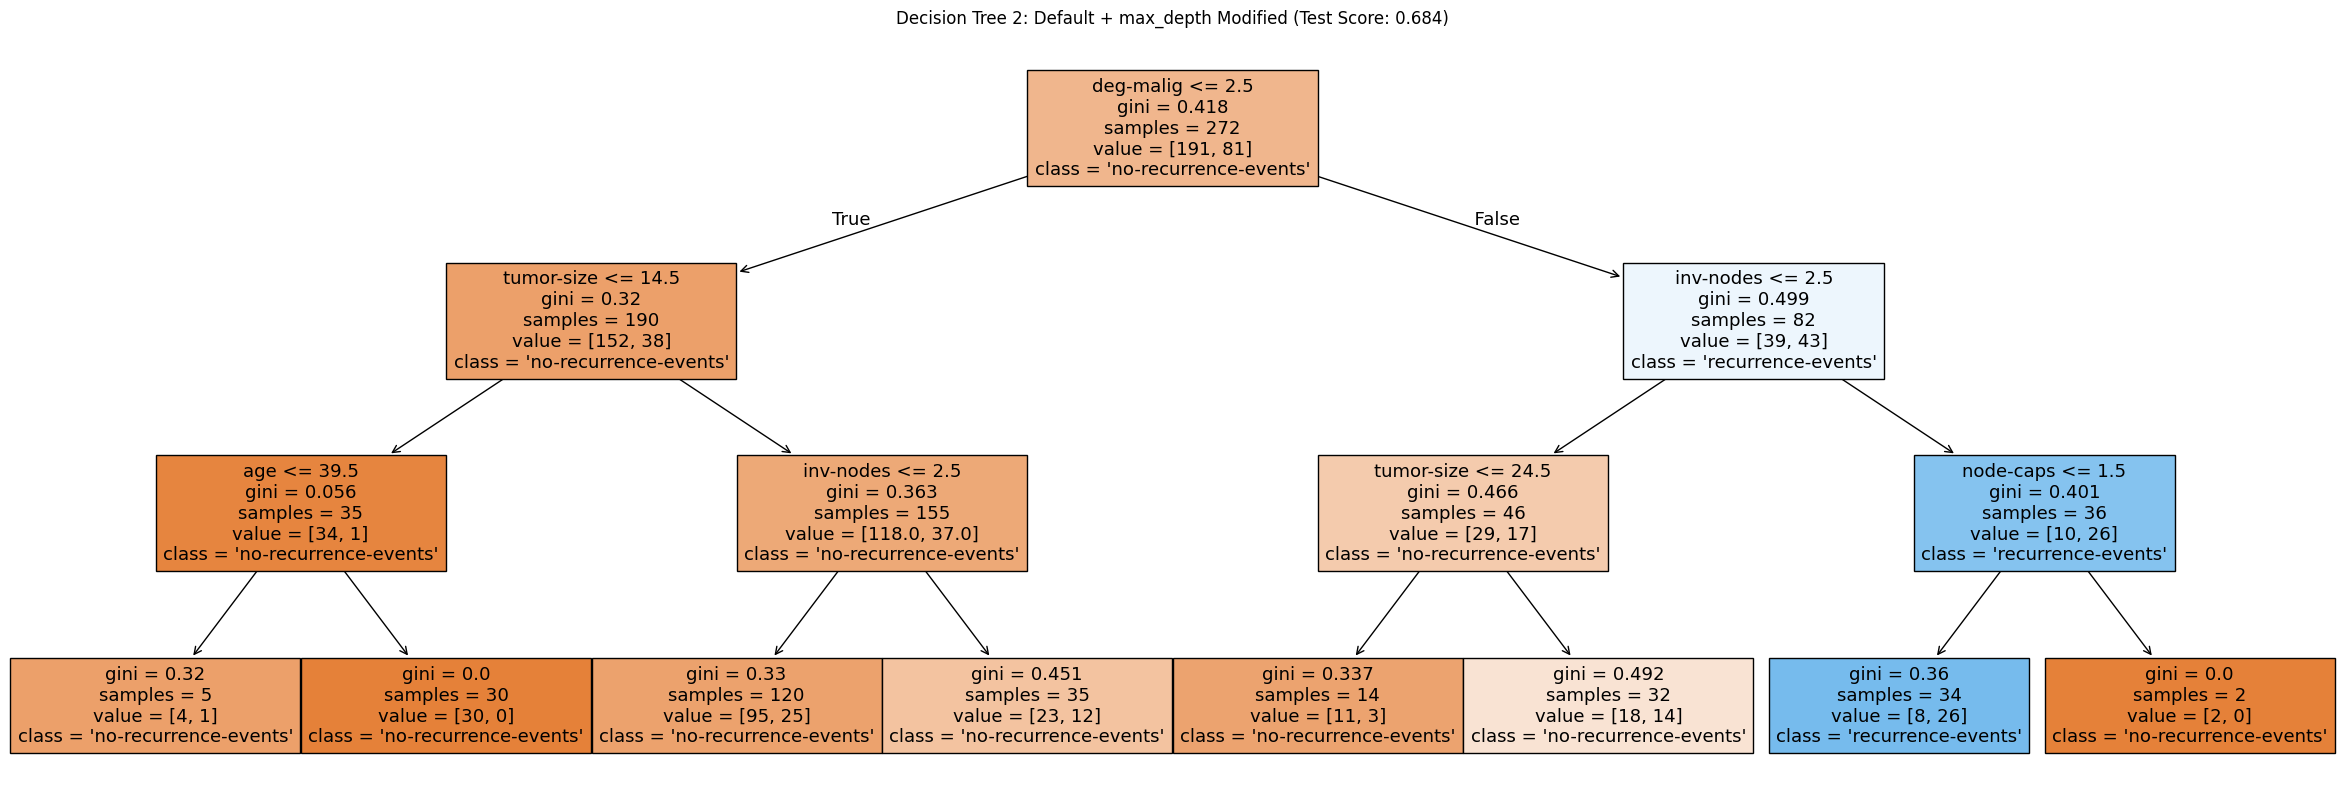

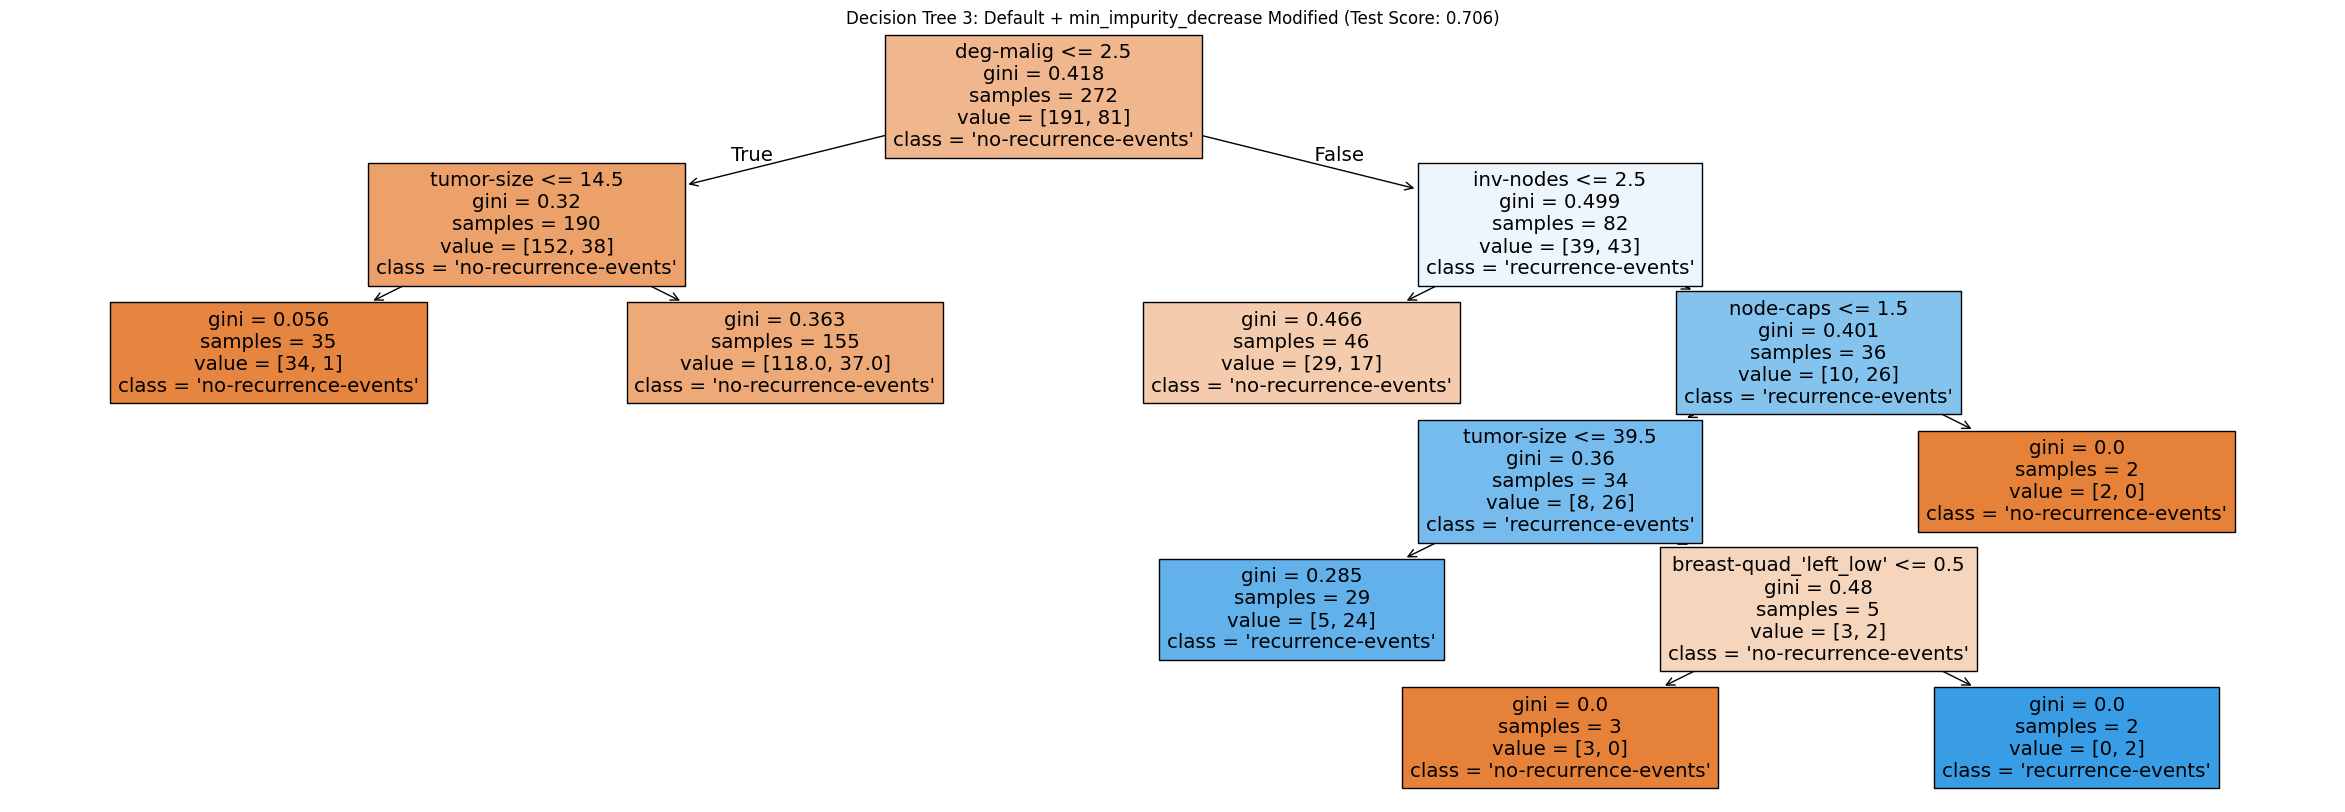

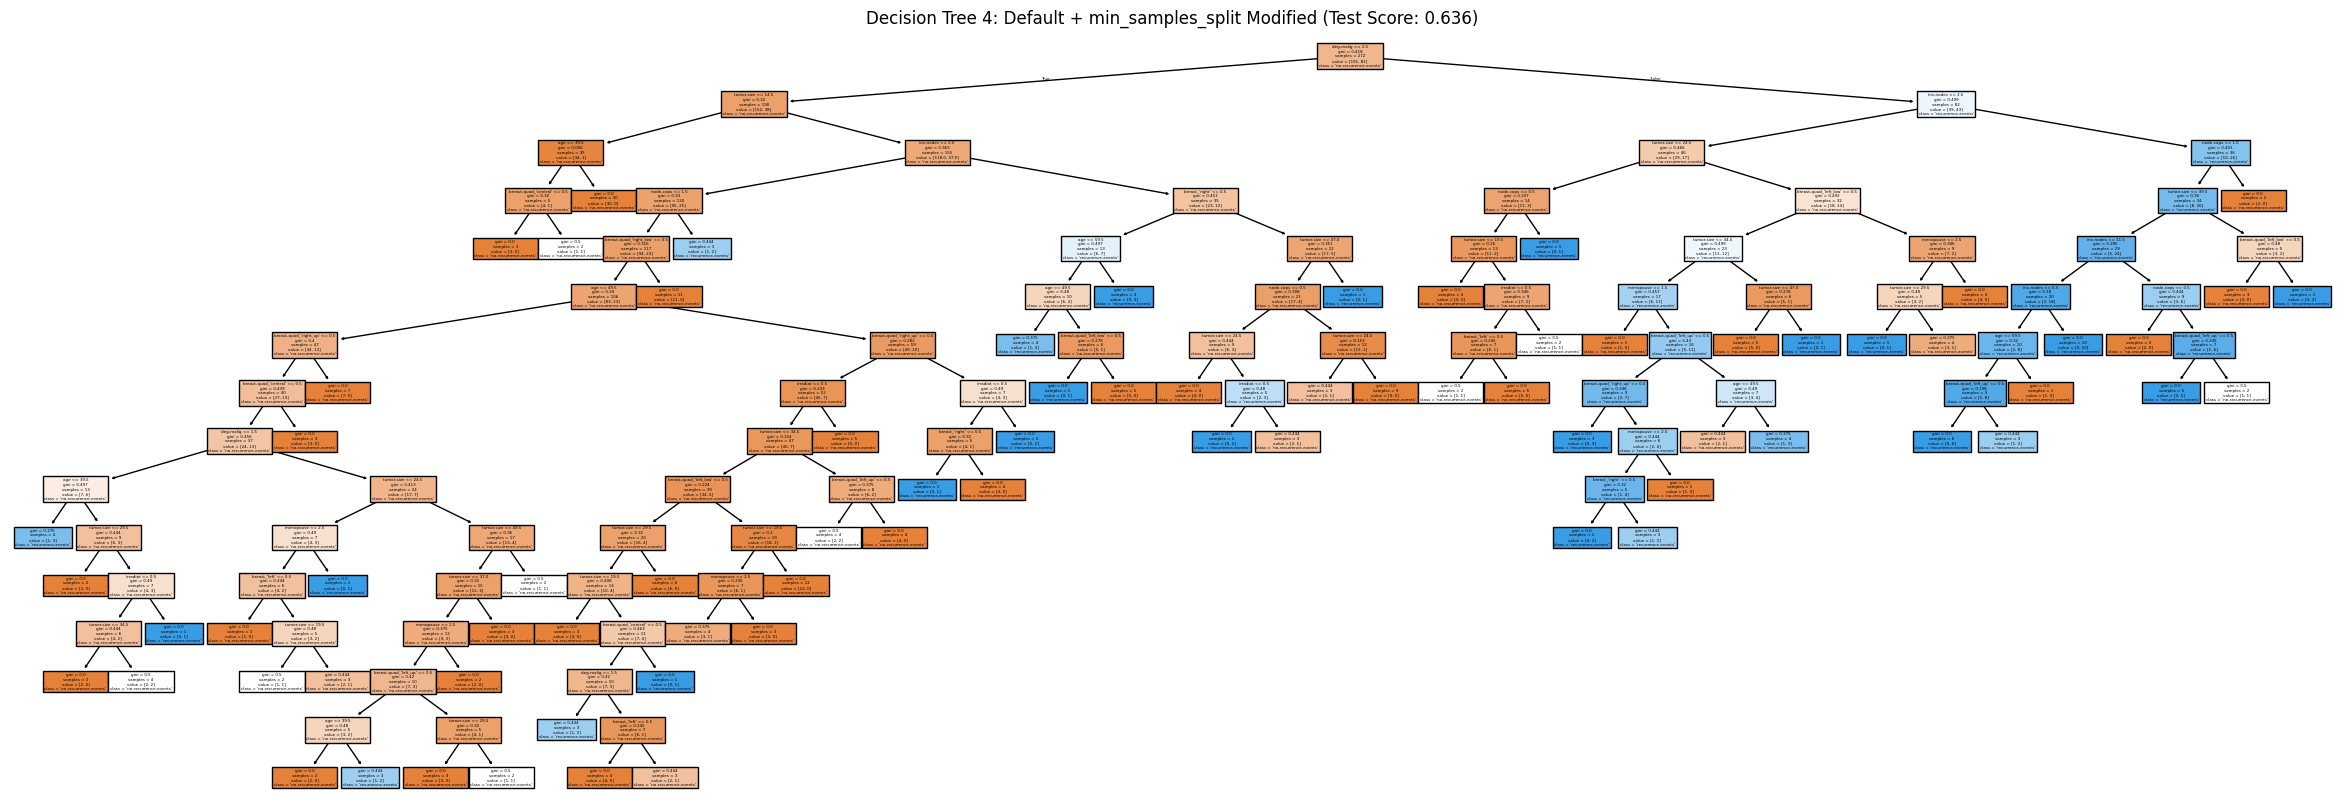

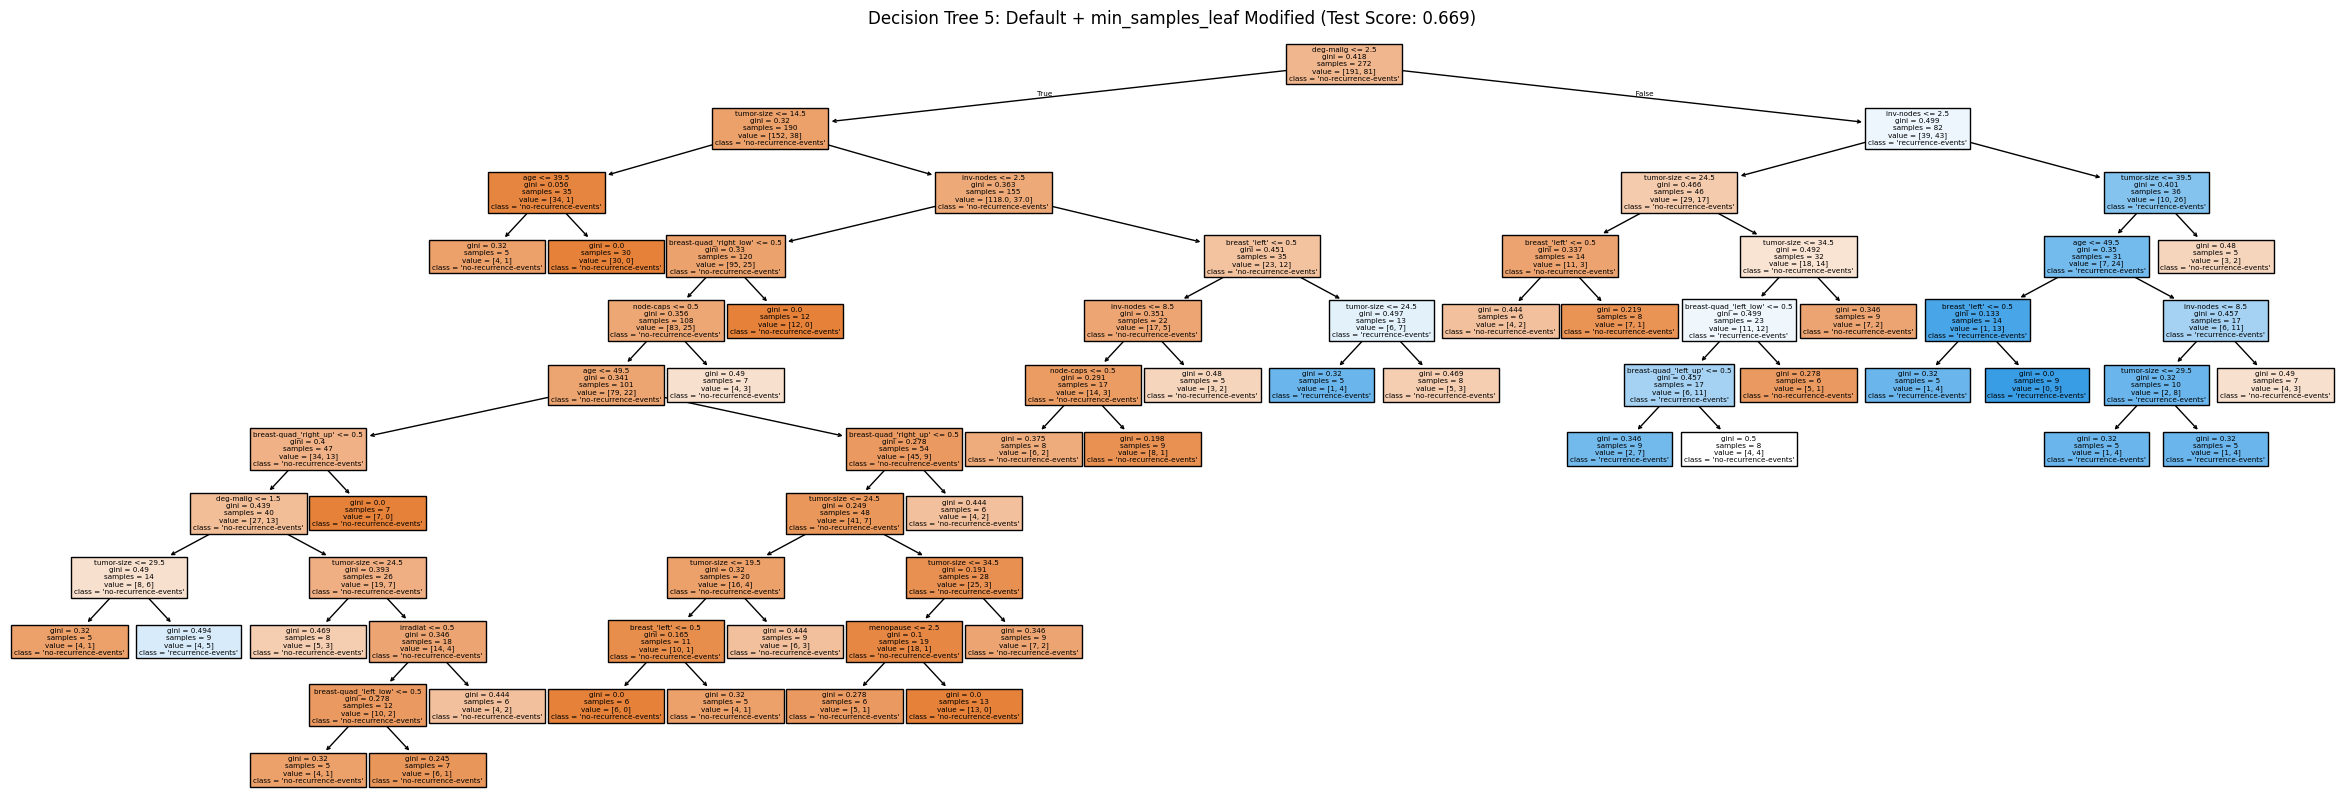

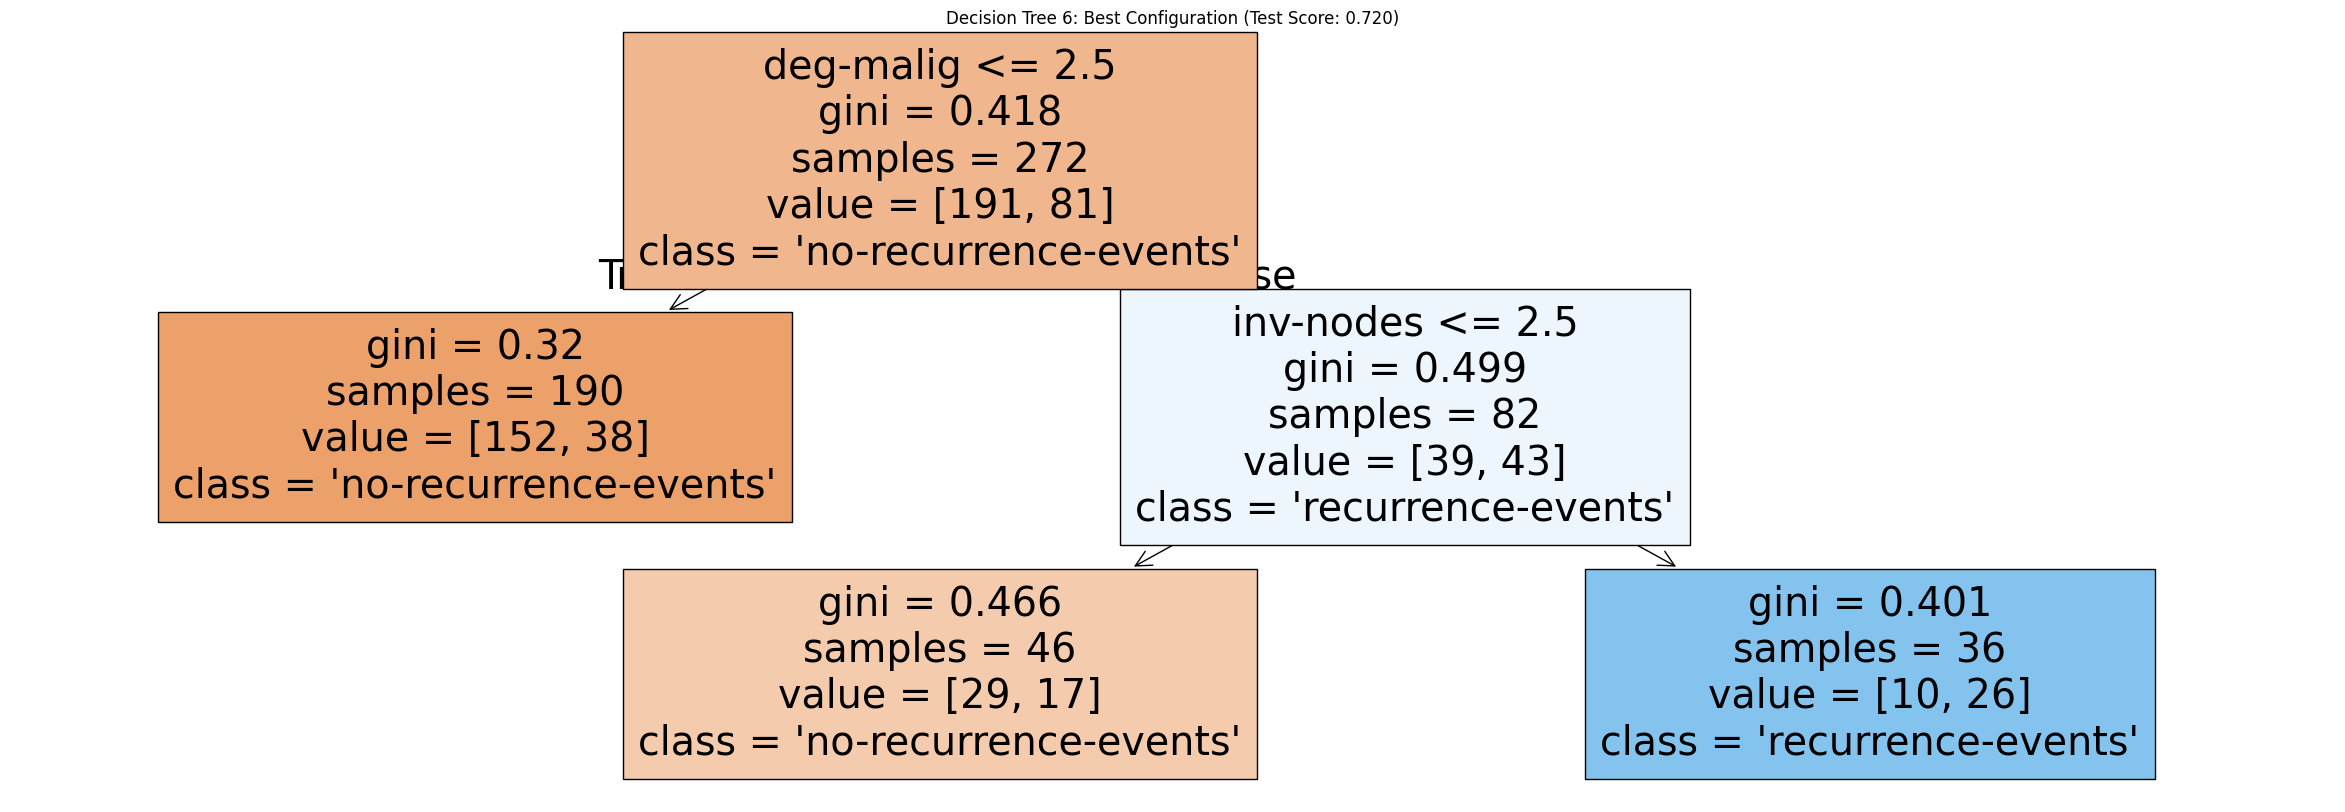

In [17]:
# Funzione per addestrare e visualizzare alberi
def visualize_decision_trees(named_configs, X, y):
    for idx, (name, config) in enumerate(named_configs, start=1):
        # Inizializza il modello
        dt_model = DecisionTreeClassifier(
            max_depth=int(config['max_depth']) if pd.notna(config['max_depth']) and config['max_depth'] != None else None,
            min_impurity_decrease=config['min_impurity_decrease'],
            min_samples_split=int(config['min_samples_split']),
            min_samples_leaf=int(config['min_samples_leaf']),
            random_state=42
        )
        # Addestra il modello
        dt_model.fit(X, y)

        # Calcola test score
        test_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
        mean_test_score = test_scores.mean()

        # Visualizza l'albero
        plt.figure(figsize=(30, 10))
        plot_tree(dt_model, feature_names=X.columns, class_names=encoder.classes_, filled=True)
        title = f"Decision Tree {idx}: {name} (Test Score: {mean_test_score:.3f})"
        plt.title(title)
        plt.show()

# Visualizza gli alberi
visualize_decision_trees(named_configs, X_encoded, y_encoded)

### Parameters and Their Effects

#### 1. `max_depth` (Maximum Depth of the Tree)
is it alredy discussed above

#### 2. `min_samples_split` (Minimum Samples Required to Split an Internal Node)
- **Low Values (e.g., 2)**:
  - Tree is allowed to split frequently, creating many branches.
  - Risk of overfitting, as the tree might grow excessively complex.
- **High Values (e.g., 10)**:
  - Reduces the number of splits, leading to a simpler tree.
  - May result in underfitting if the threshold prevents the tree from capturing important splits.

#### 3. `min_samples_leaf` (Minimum Samples Required to Be at a Leaf Node)
- **Low Values (e.g., 1)**:
  - Allows the tree to have leaves with very few samples.
  - Risk of overfitting, as leaves with very few samples may not generalize well.
- **High Values (e.g., 5)**:
  - Forces leaves to have more samples, making the tree more conservative.
  - May result in underfitting if important patterns are missed due to larger leaves.

#### 4. `min_impurity_decrease` (Minimum Reduction in Impurity for a Split to Be Considered)
- **Low Values (e.g., 0.0)**:
  - Splits occur more frequently, as even minimal reductions in impurity are accepted.
  - Can lead to overfitting by creating unnecessary splits.
- **High Values (e.g., 0.1)**:
  - Splits occur less frequently, as only significant reductions in impurity are allowed.
  - Risk of underfitting if important splits are skipped due to the higher threshold.

---

The tree with the highest accuracy has only 3 leaves and no pure partitions because it prioritizes generalization over perfect separation of the training data. Fewer leaves indicate a simpler model that avoids overfitting, effectively capturing the most important patterns without focusing on noise or minor details. The absence of pure partitions means the tree balances class distributions in its leaves, reflecting a broader decision-making process that performs well across both training and unseen data.

# Exercise 3-4

## Validation of a classification model using Cross Validation

Cross-validation is a technique used to assess the performance and generalization ability of machine learning models, particularly in the context of classification tasks. It involves partitioning the dataset into multiple subsets, known as folds.

1. **Partitioning the Dataset**: The dataset is divided into k equal-sized folds.

2. **Training and Testing**: The model is trained k times, each time using k-1 folds for training and the remaining fold for testing.

3. **Evaluation**: The performance of the model is evaluated on each fold, and the results are averaged to obtain a robust estimate of the model's performance.

4. **Advantages**: Cross-validation provides a more reliable estimate of the model's performance compared to a single train-test split. It helps to detect overfitting and assesses the model's ability to generalize to unseen data.

[Use `cross_val_score` and `cross_val_predict` to perform cross-validation easily. Follow the same instruction of Exercise 1 to initialise and use the model]

In [18]:
def evaluate_decision_tree(config, X, y, cv=10):
    # Initialize the model with the specified configuration
    dt_model = DecisionTreeClassifier(
        max_depth=int(config['max_depth']) if pd.notna(config['max_depth']) and config['max_depth'] != None else None,
        min_impurity_decrease=config['min_impurity_decrease'],
        min_samples_split=int(config['min_samples_split']),
        min_samples_leaf=int(config['min_samples_leaf']),
        random_state=42
    )

    # Compute mean accuracy using cross-validation
    scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')
    mean_accuracy = scores.mean()

    # Generate predictions for confusion matrix
    y_pred = cross_val_predict(dt_model, X, y, cv=cv)
    conf_matrix = confusion_matrix(y, y_pred)

    return mean_accuracy, conf_matrix



In [19]:
def plot_confusion_matrix(conf_matrix, name, mean_accuracy, classes):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {name} (Accuracy: {mean_accuracy:.3f})")
    plt.show()


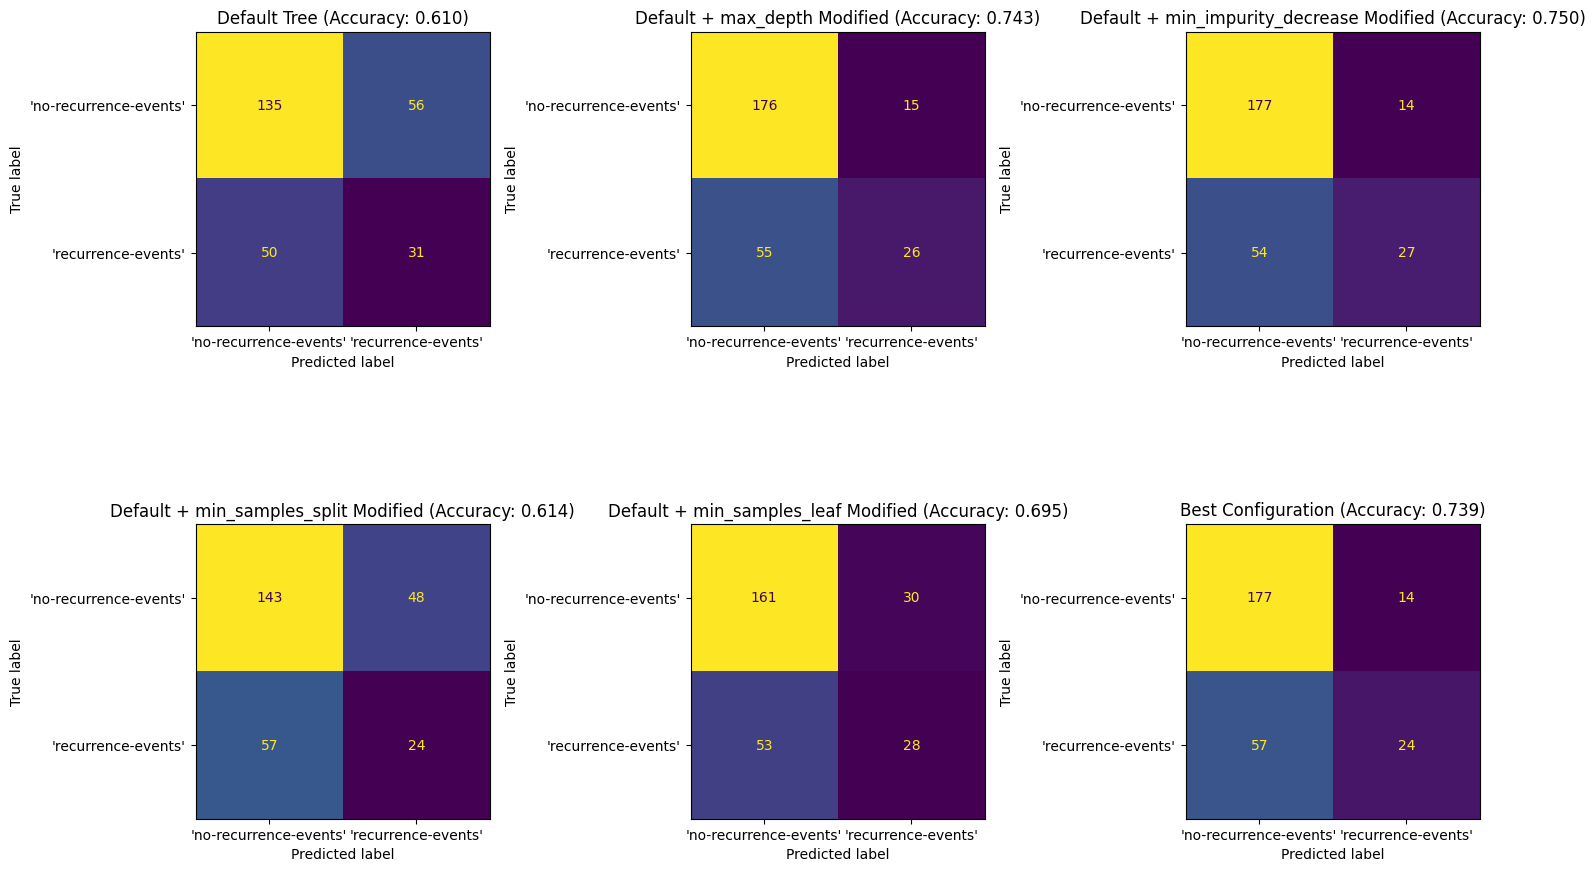

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

for ax, (name, config) in zip(axes.flatten(), named_configs):
    mean_accuracy, conf_matrix = evaluate_decision_tree(config, X_encoded, y_encoded)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoder.classes_)
    disp.plot(cmap='viridis', ax=ax, colorbar=False)

    ax.set_title(f"{name} (Accuracy: {mean_accuracy:.3f})")

plt.tight_layout()
plt.show()

# The Impact of Decision Tree Parameters on Accuracy

Decision Trees are sensitive to hyperparameters like **min impurity decrease**, **min samples to split**, **min samples per leaf**, and **max depth**. These parameters directly affect how well the tree generalizes versus overfits. Here’s a quick breakdown:

## 1. Minimal Impurity Decrease
- **Low Values (`0.0`)**: More splits → Detailed trees. Risk: Overfitting.
- **High Values (`0.01`)**: Fewer splits → Simpler trees. Risk: Underfitting.

## 2. Min Samples to Split
- **Low (`2`)**: Deep trees → Overfitting.
- **High (`10`)**: Shallow trees → Underfitting.

## 3. Min Samples Per Leaf
- **Low (`1`)**: Tiny leaves → Sensitive to noise.
- **High (`5`)**: Larger leaves → Better stability.

## 4. Max Depth
- **Low (`5`)**: Restricts complexity → Generalization improves.
- **High (`None`)**: Deep trees → Overfitting risk.

### Key Takeaways:
- **Underfitting**: Happens when parameters are too restrictive, resulting in overly simple trees.
- **Overfitting**: Happens with low constraints, creating overly complex trees.
- **Balance**: Optimal accuracy comes from tuning parameters using cross-validation to fit the dataset.

I use a scaler because K-NN relies on distance calculations, which are sensitive to the scale of the features. Without scaling, features with larger ranges can dominate the distance metric, leading to biased results. Standardizing the features ensures that all dimensions contribute equally to the model’s decisions.

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

def evaluate_knn(X, y, k_values, cv=10):
    results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Calculate mean accuracy with cross-validation
        scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        mean_accuracy = scores.mean()

        # Generate predictions for confusion matrix
        y_pred = cross_val_predict(knn, X, y, cv=cv)
        conf_matrix = confusion_matrix(y, y_pred)

        results[k] = (mean_accuracy, conf_matrix)
    return results

# Define K values to test
k_values = [5, 10, 15, 20, 25, 30]

# Evaluate K-NN
knn_results = evaluate_knn(X_scaled, y_encoded, k_values)

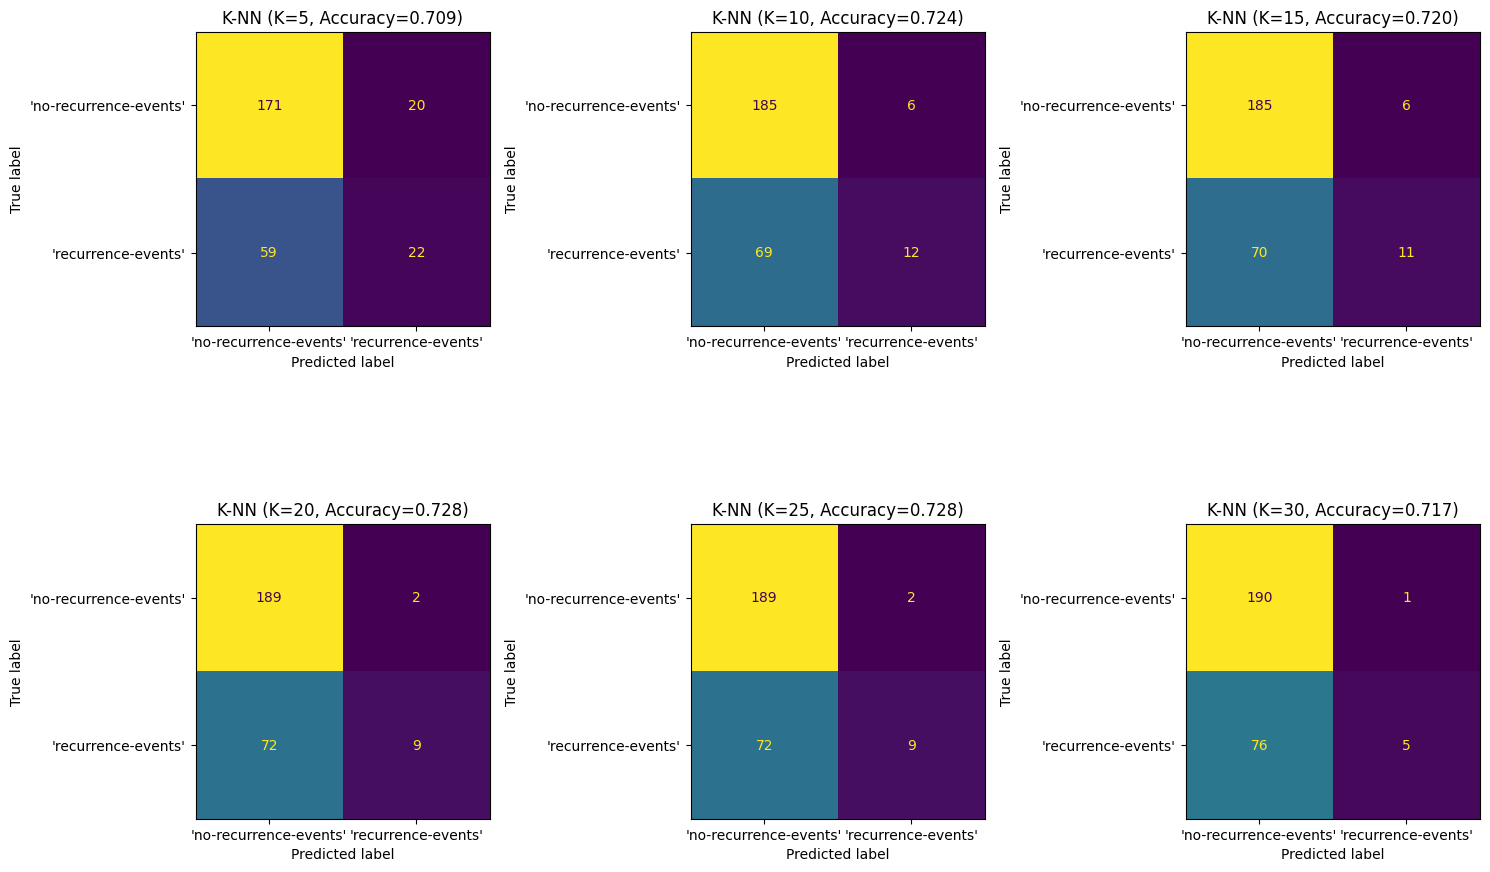

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns (adjusted height)

# Iterate over the K values and plot confusion matrices
for ax, (k, (accuracy, conf_matrix)) in zip(axes.flatten(), knn_results.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoder.classes_)
    disp.plot(cmap='viridis', ax=ax, colorbar=False)  # Plot without separate colorbars for consistency
    ax.set_title(f"K-NN (K={k}, Accuracy={accuracy:.3f})")

plt.tight_layout()
plt.show()


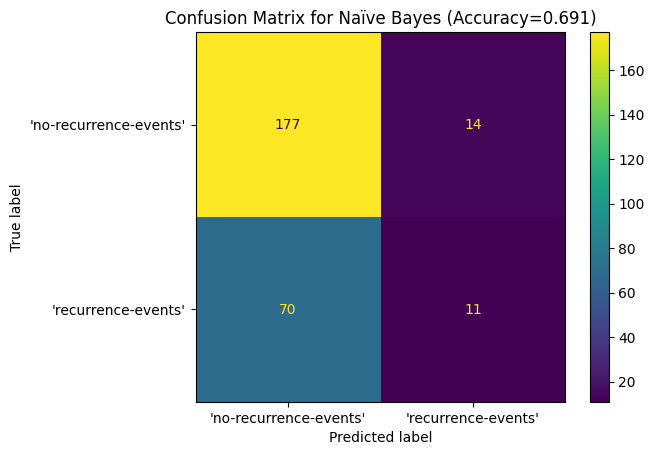

In [23]:
nb_classifier = GaussianNB()

nb_scores = cross_val_score(nb_classifier, X_encoded, y_encoded, cv=10, scoring='accuracy')
nb_mean_accuracy = nb_scores.mean()


nb_y_pred = cross_val_predict(nb_classifier, X_encoded, y_encoded, cv=10)
nb_conf_matrix = confusion_matrix(y_encoded, nb_y_pred)

# Plot confusion matrix for Naïve Bayes
disp = ConfusionMatrixDisplay(confusion_matrix=nb_conf_matrix, display_labels=encoder.classes_)
disp.plot(cmap='viridis')
plt.title(f"Confusion Matrix for Naïve Bayes (Accuracy={nb_mean_accuracy:.3f})")
plt.show()

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best Accuracy: 0.75


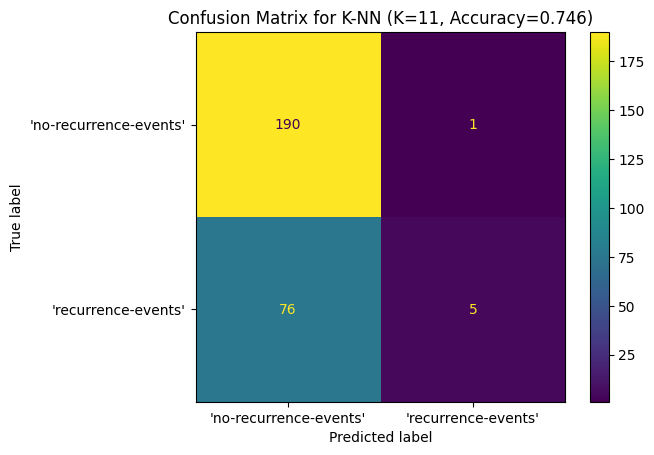

In [24]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(5, 25),  # Tests K da 1 a 20
    'weights': ['uniform', 'distance'],  # 2 weight tipe
    'metric': ['euclidean', 'manhattan', 'minkowski']  # many distance metrics
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_scaled, y_encoded)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoder.classes_)
disp.plot(cmap='viridis')
plt.title(f"Confusion Matrix for K-NN (K={grid_search.best_params_['n_neighbors']}, Accuracy={grid_search.best_score_:.3f})")
plt.show()

The **impact of parameter \( K \)** on the K-Nearest Neighbor (K-NN) classifier's accuracy was evaluated using 10-fold Stratified Cross-Validation. As \( K \) increases, the accuracy improves consistently, stabilizing for larger values.

- The **average accuracy** for K-NN across the tested values of \( K \) is **0.719**.
- The **Naïve Bayes classifier** achieved an accuracy of **0.691**, slightly lower than the average performance of K-NN, but lower than K-NN's best configuration (\( K=11, Accuracy=0.746\)).


Naïve Bayes performed comparably to the average K-NN classifier, but that result could represent a correletion between some features. However, K-NN can surpass Naïve Bayes when appropriately tuned, as seen with \( K=11 \).

# Exercise 5

### Correlation Analysis

1. **Naïve Independence Assumption**:
   - The Naïve independence assumption does **not** hold for the Breast dataset. Several attribute pairs exhibit moderate to strong correlations, suggesting that the features are not entirely independent.

2. **Most Correlated Attributes**:
   
   - The pair of most correlated attributes is `age` and `menopause`, with a correlation coefficient of **0.63**.
   - The second pair of most correlated attributes is `inv-nodes` and `node-caps`, with a correlation coefficient of **0.33**.

3. **Implications**:
   - These correlations highlight dependencies between features, which can impact the assumptions underlying certain models like Naïve Bayes.

Below is the heatmap showing the correlation matrix for all attributes.

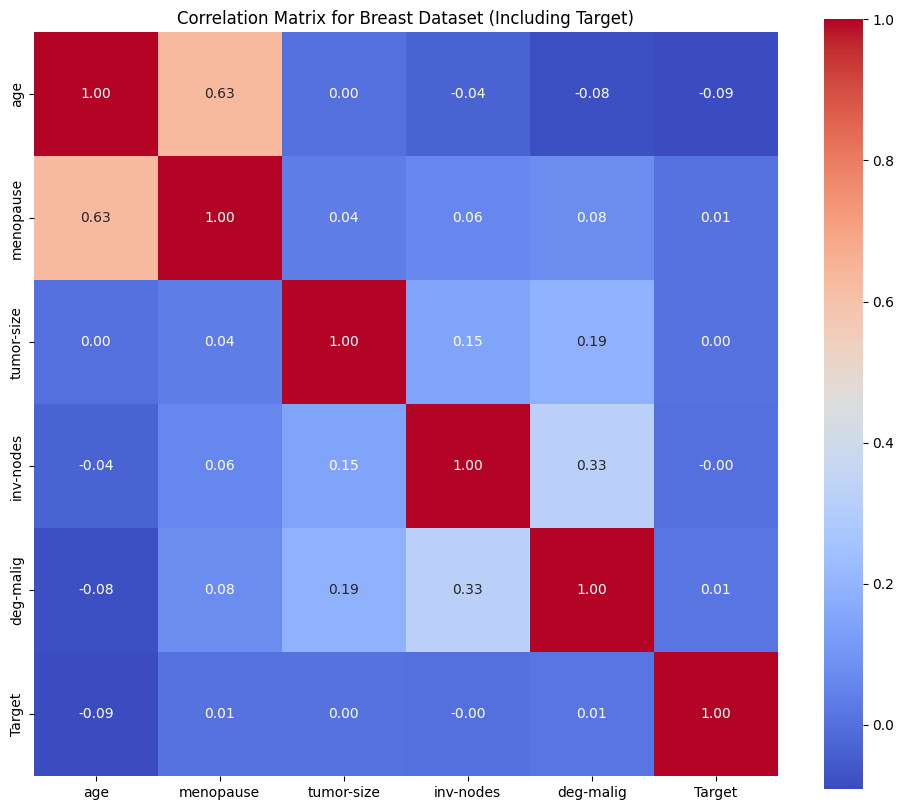

The most correlated attributes are: ('menopause', 'age')
Correlation value: 0.63


In [25]:
numeric_columns = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'deg-malig']

data_with_target = pd.concat([X_encoded[numeric_columns], pd.Series(y_encoded, name='Target')], axis=1)

correlation_matrix = data_with_target.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix for Breast Dataset (Including Target)")
plt.show()

correlation_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
most_correlated_pair = correlation_pairs[correlation_pairs < 1].idxmax()
most_correlation_value = correlation_pairs[most_correlated_pair]

print(f"The most correlated attributes are: {most_correlated_pair}")
print(f"Correlation value: {most_correlation_value:.2f}")
